# Imports

In [1]:
import numpy as np
from iminuit.cost import LeastSquares
from iminuit import Minuit
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex', 'grid']) #ieee, grid

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

from funcs import *
from stats import *
from Fit import *

# Functions

In [73]:
def H_R(w,tau, a):
    return w*tau/np.sqrt(1+np.power(w*tau,2)) + a

def H_C(w,tau, a):
    return 1/np.sqrt(1+np.power(w*tau,2)) + a

def fase_R(w,tau, a):
    return np.arctan(1/(w*tau)) + a

def fase_C(w,tau, a, b):
    return -np.arctan(w*tau + b) + a

# Esempio

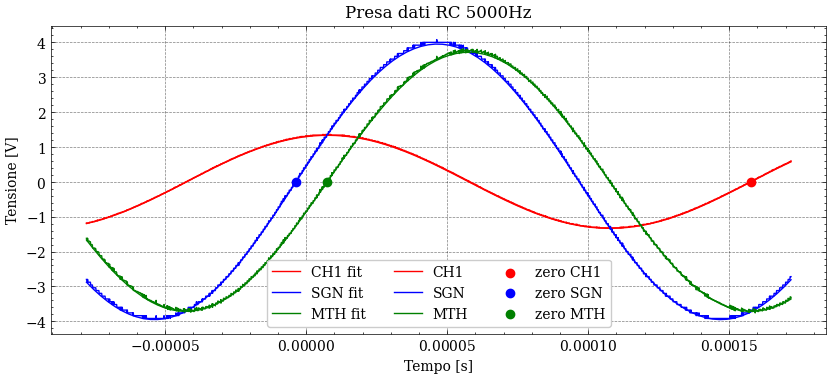

In [86]:
CH1,SGN,MTH, V_SGN, V_MTH, zero_CH1, zero_SGN, zero_MTH, m1, m2, m3, dt_CH1, dt_MTH, V_SGN_err, V_MTH_err, zero_err = analize('data.leo/RC/5000/', 5000, force=True, prec=1e-9,verbose=True)
        
x=np.linspace(np.min(CH1[0]), np.max(CH1[0]), 100)
plt.figure(figsize=(10,4))
plt.title('Presa dati RC 5000Hz')
plt.plot(x, sine(x, **m1.values.to_dict()), label='CH1 fit', color='red')
plt.plot(x, sine(x, **m2.values.to_dict()), label='SGN fit', color='blue')
plt.plot(x, sine(x, **m3.values.to_dict()), label='MTH fit', color='green')

plt.plot(CH1[0], CH1[1], label='CH1', color='red')
plt.plot(SGN[0], SGN[1], label='SGN', color='blue')
plt.plot(MTH[0], MTH[1], label='MTH', color='green')

plt.scatter(zero_CH1, 0, color='red', label='zero CH1')
plt.scatter(zero_SGN, 0, color='blue', label='zero SGN')
plt.scatter(zero_MTH, 0, color='green', label='zero MTH')

plt.xlabel('Tempo [s]')
plt.ylabel('Tensione [V]')
plt.legend(ncol=3)
plt.savefig('imgs/presa_dati.pdf', bbox_inches='tight')

# Presa Dati

In [3]:
if 1:
    path_folder = 'data.leo/RC/'
    V_res, V_c, fase_res, fase_c, freqs, V_res_err, V_c_err, fase_err = [], [], [], [], [], [], [], []

    for i in sorted([int(i) for i in os.listdir(path_folder)]):

        path = path_folder+str(i)+'/'

        CH1,SGN,MTH, V_SGN, V_MTH, zero_CH1, zero_SGN, zero_MTH, m1, m2, m3, dt_CH1, dt_MTH, V_SGN_err, V_MTH_err, zero_err = analize(path, i, force=True, prec=1e-9,verbose=True)
        
        # x=np.linspace(np.min(CH1[0]), np.max(CH1[0]), 100)
        # plt.figure(figsize=(10,4))
        # plt.plot(x, sine(x, **m1.values.to_dict()), label='CH1 fit', color='red')
        # plt.plot(x, sine(x, **m2.values.to_dict()), label='SGN fit', color='blue')
        # plt.plot(x, sine(x, **m3.values.to_dict()), label='MTH fit', color='green')
        
        # # plt.plot(CH1[0], CH1[1], label='CH1', color='red')
        # # plt.plot(SGN[0], SGN[1], label='SGN', color='blue')
        # # plt.plot(MTH[0], MTH[1], label='MTH', color='green')

        # plt.scatter(zero_CH1, 0, color='red', label='zero CH1')
        # plt.scatter(zero_SGN, 0, color='blue', label='zero SGN')
        # plt.scatter(zero_MTH, 0, color='green', label='zero MTH')
        # plt.legend(ncol=2)
        # plt.show()
        # print(i, dt_CH1, dt_MTH)

        V_res.append(V_SGN)
        V_c.append(V_MTH)
        V_res_err.append(V_SGN_err)
        V_c_err.append(V_MTH_err)
        fase_res.append(dt_CH1*i*2*np.pi)
        fase_c.append(dt_MTH*i*2*np.pi)
        freqs.append(i)
        fase_err.append(zero_err)

    V_res = np.array(V_res)
    V_c = np.array(V_c)
    V_res_err = np.array(V_res_err)
    V_c_err = np.array(V_c_err)
    fase_res = np.array(fase_res)
    fase_c = np.array(fase_c)
    freqs = np.array(freqs)
    fase_err = np.array(fase_err)

# Modulo $|H|$

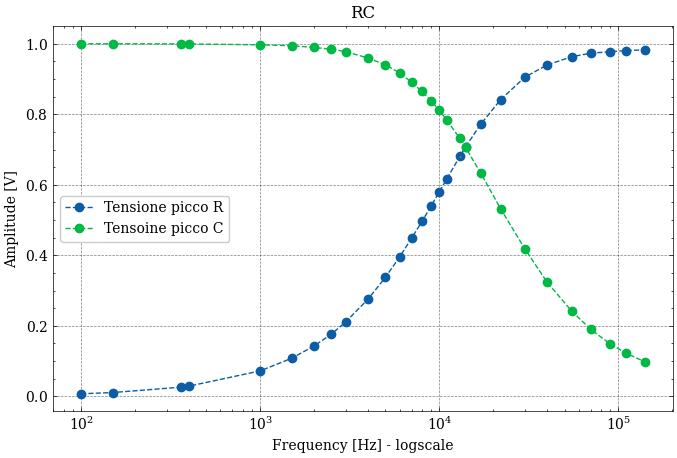

In [4]:
plt.figure(figsize=(8,5))
x = np.linspace(np.min(freqs),np.max(freqs),1000)

# plt.plot(x, H_R(x*2*np.pi, 1e3*12e-9, 0), label='Teorico')
# plt.plot(x, H_C(x*2*np.pi, 1e3*12e-9), label='Teorico')
plt.plot(freqs, V_res, 'o--', label='Tensione picco R')
plt.plot(freqs, V_c, 'o--', label='Tensoine picco C')
plt.errorbar(freqs, V_res, yerr=V_res_err,linestyle='None')
plt.errorbar(freqs, V_c, yerr=V_c_err, linestyle='None')
plt.title('RC')
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Amplitude [V]')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.show()

# Fase $\phi(H)$

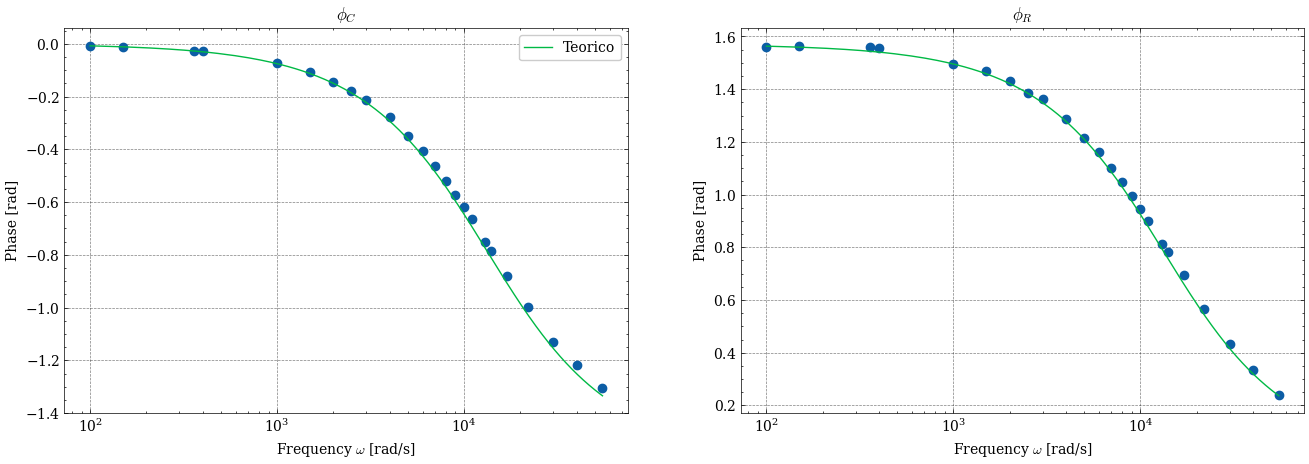

In [5]:
x = np.linspace(np.min(freqs[:-4]),np.max(freqs[:-4]),1000)

plt.subplots(1,2,figsize=(16,5))
plt.title('Dati')
plt.subplot(1,2,1)
plt.plot(freqs[:-4], -fase_c[:-4],'o', lw=1)
plt.plot(x, fase_C(x*2*np.pi, 1e3*12e-9, 0.), label='Teorico')
plt.title('$\phi_C$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.legend()
plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(freqs[:-4], -fase_res[:-4] + np.pi*2, 'o', lw=1)
plt.plot(x, fase_R(x*2*np.pi, 1e3*12e-9, 0), label='Teorico')
plt.title('$\phi_R$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.xscale('log')

# plt.savefig('imgs/RC/fasi_no_log.jpeg', bbox_inches='tight', dpi=200)
plt.show()

# R

In [91]:
c = LeastSquares(freqs*2*np.pi, V_res, V_res_err, H_R)
f_m = Minuit(c, tau=1e3*12e-9, a=0)
f_m.fixed['a'] = True
f_m.migrad()
f_m.hesse()
print(f_m.values['tau']/995, '1.14689623663691⋅e-11')

1.1427810630697654e-08 1.14689623663691⋅e-11


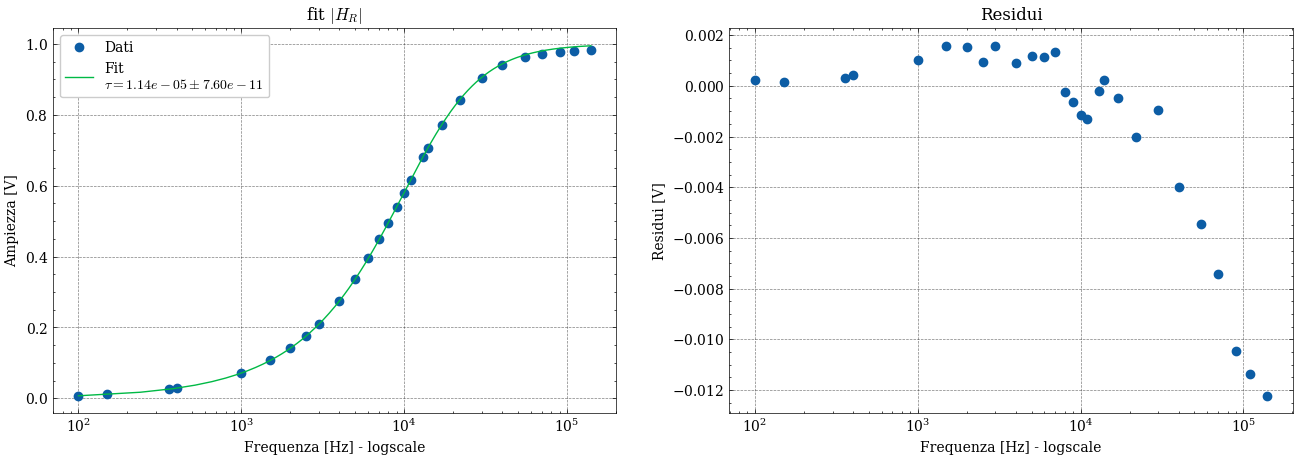

In [68]:
plt.subplots(1,2,figsize=(16,5))
plt.subplot(1,2,1)
x = np.linspace(np.min(freqs),np.max(freqs),1000)
plt.plot(freqs, V_res, 'o', label='Dati')
plt.plot(x, H_R(x*2*np.pi, f_m.values['tau'], f_m.values['a']), label='Fit\n'f'$\\tau = {f_m.values["tau"]:.2e} \pm {f_m.errors["tau"]:.2e}$')
plt.errorbar(freqs, V_res, yerr=V_res_err, linestyle='None')
plt.title('fit $|H_R|$')
plt.xlabel('Frequenza [Hz] - logscale')
plt.ylabel('Ampiezza [V]')
plt.xscale('log')
plt.legend()

plt.subplot(1,2,2)
res = V_res - H_R(freqs*2*np.pi, f_m.values['tau'], f_m.values['a'])
plt.scatter(freqs, res)
plt.title('Residui')
plt.xlabel('Frequenza [Hz] - logscale')
plt.ylabel('Residui [V]')
plt.xscale('log')
plt.savefig('imgs/RC/H_R_mod.pdf', bbox_inches='tight')

In [94]:
c = LeastSquares(freqs*2*np.pi, -fase_res + np.pi*2, 0.005, fase_R)
f_f = Minuit(c, tau=1e3*12e-9, a=0)
f_f.migrad()
f_f.hesse()
print(f_f.values['tau'], f_f.errors['tau'])
print(f_f.values['tau']/995)

1.1546920378298746e-05 6.444765221706226e-08
1.1604945103817835e-08


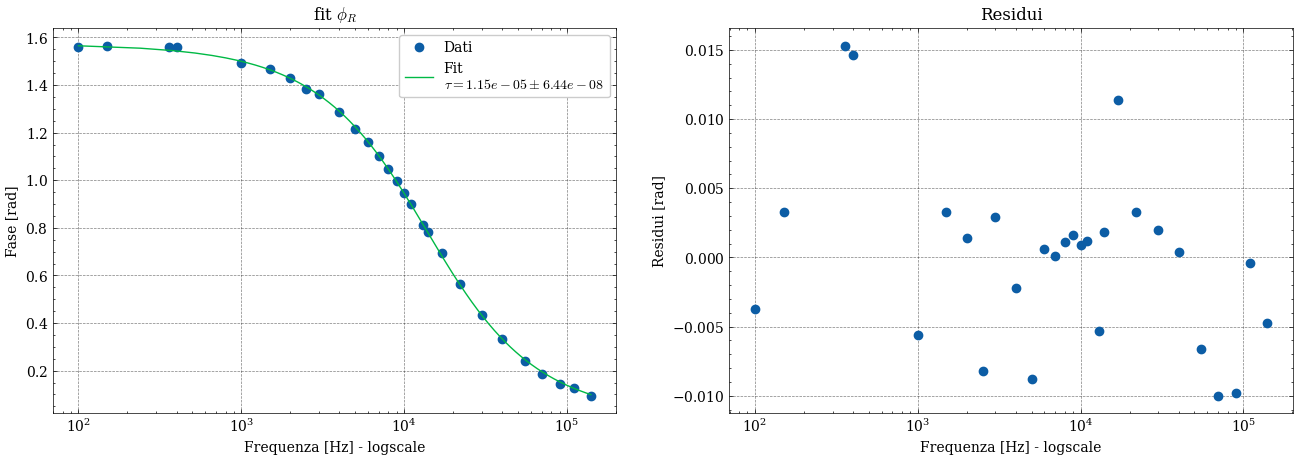

In [69]:
plt.subplots(1,2,figsize=(16,5))
plt.title('RC')
plt.subplot(1,2,1)
x = np.linspace(np.min(freqs),np.max(freqs),1000)
plt.plot(freqs, -fase_res + np.pi*2, 'o', label='Dati')
plt.plot(x, fase_R(x*2*np.pi, f_f.values['tau'], f_f.values['a']), label='Fit\n'f'$\\tau = {f_f.values["tau"]:.2e} \pm {f_f.errors["tau"]:.2e}$')
plt.errorbar(freqs, -fase_res + np.pi*2, yerr=fase_err, linestyle='None')
plt.title('fit $\phi_R$')
plt.xlabel('Frequenza [Hz] - logscale')
plt.ylabel('Fase [rad]')
plt.xscale('log')
plt.legend()

plt.subplot(1,2,2)
res = -fase_res + np.pi*2 - fase_R(freqs*2*np.pi, f_f.values['tau'], f_f.values['a'])
plt.scatter(freqs, res)
plt.title('Residui')
plt.xlabel('Frequenza [Hz] - logscale')
plt.ylabel('Residui [rad]')
plt.xscale('log')
plt.savefig('imgs/RC/H_R_fase.pdf', bbox_inches='tight')

In [71]:
# plt.subplots(1,2,figsize=(16,5))
# x = np.linspace(np.min(freqs[2:]),np.max(freqs[2:]),1000)
# plt.subplot(1,2,1)
# plt.title("$|H_R|$")
# plt.scatter(freqs[2:], V_res[2:], lw=1, label='Dati')
# plt.plot(x, H_R(x*2*np.pi, f_m.values['tau'], f_m.values['a']), label='fit\n'+r'$\tau = $'f'{"{:.2e}".format(f_m.values["tau"])}''$\pm$'f'{"{:.1e}".format(f_m.errors["tau"])}', color='red')
# plt.xscale('log')
# plt.xlabel('$\omega$ [rad/s]')
# plt.ylabel('Amplitude [V]')
# plt.legend()

# plt.subplot(1,2,2)
# plt.title("$\phi_R$")
# plt.scatter(freqs[2:], -fase_res[2:]+(np.pi*2), lw=1, label='Dati')
# plt.plot(x, fase_R(x*2*np.pi, f_f.values['tau'], f_f.values['a']), label='fit\n'+r'$\tau = $'f'{"{:.2e}".format(f_f.values["tau"])}''$\pm$'f'{"{:.1e}".format(f_f.errors["tau"])}', color='red')
# plt.xscale('log')
# plt.xlabel('$\omega$ [rad/s]')
# plt.ylabel('$\Delta$Phase [rad]')
# plt.legend()

# C

In [148]:
c = LeastSquares(freqs*2*np.pi, V_c, V_c_err*200, H_C)
f_m = Minuit(c, tau=1e3*12e-9, a=0)
f_m.fixed['a'] = True
f_m.migrad()
f_m.hesse()
print(f_m.values['tau'], f_m.errors['tau'])
print(f_m.values['tau']/995)

1.1513653270535565e-05 1.7791926588839684e-08
1.157151082465886e-08


0.2556455253648954

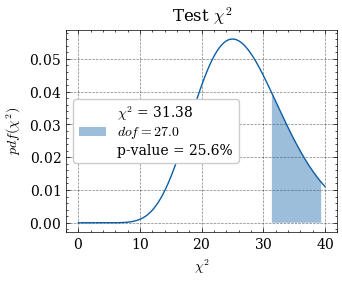

In [145]:
chi_test(f_m.fval, f_m.ndof)

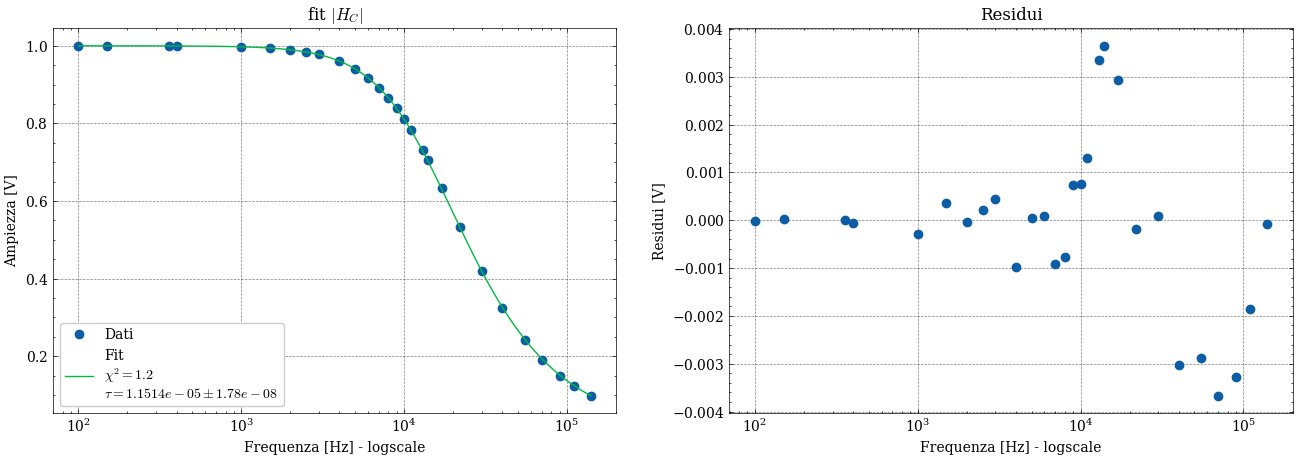

In [152]:
plt.subplots(1,2,figsize=(16,5))
plt.subplot(1,2,1)
x = np.linspace(np.min(freqs),np.max(freqs),1000)
plt.plot(freqs, V_c, 'o', label='Dati')
plt.plot(x, H_C(x*2*np.pi, f_m.values['tau'], f_m.values['a']), label='Fit\n'f'$\chi^2 = {f_m.fval/f_m.ndof:.1f}$\n'f'$\\tau = {f_m.values["tau"]:.4e} \pm {f_m.errors["tau"]:.2e}$')
plt.errorbar(freqs, V_c, yerr=V_c_err, linestyle='None')
plt.title('fit $|H_C|$')
plt.xlabel('Frequenza [Hz] - logscale')
plt.ylabel('Ampiezza [V]')
plt.xscale('log')
plt.legend()

plt.subplot(1,2,2)
res = V_c - H_C(freqs*2*np.pi, f_m.values['tau'], f_m.values['a'])
plt.scatter(freqs, res)
plt.title('Residui')
plt.xlabel('Frequenza [Hz] - logscale')
plt.ylabel('Residui [V]')
plt.xscale('log')

plt.savefig('imgs/RC/H_C_mod.pdf', bbox_inches='tight')

In [116]:
fase_c_err = np.ones_like(fase_c)*1e-8*2*np.pi*freqs

In [155]:
c = LeastSquares(freqs[:-4]*2*np.pi, -fase_c[:-4], fase_c_err[:-4], fase_C)
f_f = Minuit(c, tau=1e3*12e-9, a=0, b=0)
f_f.migrad()
f_f.hesse()
print(f_f.values['tau'], f_f.errors['tau'])
print(f_f.values['tau']/995)

1.1501424058895807e-05 4.915495521313445e-09
1.1559220159694278e-08


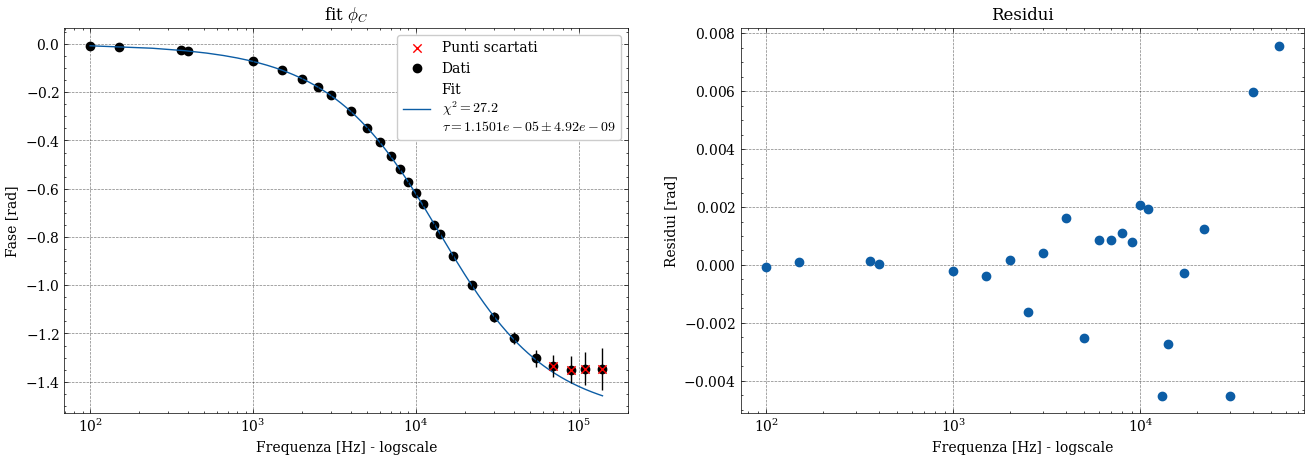

In [158]:
plt.subplots(1,2,figsize=(16,5))

plt.subplot(1,2,1)
plt.scatter(freqs[-4:], -fase_c[-4:], marker='x', color='red', label='Punti scartati', zorder=3)
x = np.linspace(np.min(freqs),np.max(freqs),1000)
plt.plot(freqs, -fase_c, 'o', label='Dati', c='k')
plt.plot(x, fase_C(x*2*np.pi, f_f.values['tau'], f_f.values['a'], f_f.values['b']), label='Fit\n'f'$\chi^2 = {f_f.fval/f_f.ndof:.1f}$\n'f'$\\tau = {f_f.values["tau"]:.4e} \pm {f_f.errors["tau"]:.2e}$')
plt.errorbar(freqs, -fase_c, yerr=fase_c_err*10, linestyle='None', c='k')
plt.title('fit $\phi_C$')
plt.xlabel('Frequenza [Hz] - logscale')
plt.ylabel('Fase [rad]')
plt.xscale('log')
plt.legend()

plt.subplot(1,2,2)
res = -fase_c[:-4] - fase_C(freqs[:-4]*2*np.pi, f_f.values['tau'], f_f.values['a'], f_f.values['b'])
plt.scatter(freqs[:-4], res)
plt.title('Residui')
plt.xlabel('Frequenza [Hz] - logscale')
plt.ylabel('Residui [rad]')
plt.xscale('log')
plt.savefig('imgs/RC/H_C_fase.pdf', bbox_inches='tight')

In [157]:
# x = np.linspace(np.min(freqs[2:]),np.max(freqs[2:]),1000)

# plt.subplots(1,2,figsize=(16,5))
# plt.subplot(1,2,1)
# plt.scatter(freqs[2:], V_c[2:], lw=1, label='Dati')
# plt.plot(x, H_C(x*2*np.pi, f_m.values['tau'], f_m.values['a']), label='fit\n'+r'$\tau = $'f'{"{:.2e}".format(f_m.values["tau"])}''$\pm$'f'{"{:.1e}".format(f_m.errors["tau"])}', color='red')
# plt.title("$|H_C|$")
# plt.xscale('log')
# plt.xlabel('$\omega$ [rad/s]')
# plt.ylabel('Amplitude [V]')
# plt.legend()

# plt.subplot(1,2,2)
# plt.scatter(freqs[2:], -fase_c[2:], lw=1, label='Dati')
# plt.plot(x, fase_C(x*2*np.pi, f_f.values['tau'], f_f.values['a']), label='fit\n'+r'$\tau = $'f'{"{:.2e}".format(f_f.values["tau"])}''$\pm$'f'{"{:.1e}".format(f_f.errors["tau"])}', color='red')
# plt.scatter(freqs[-4:], -fase_c[-4:], marker='x', s=30, c='r')
# plt.title("$\phi_C$")
# plt.xlabel('$\omega$ [rad/s]')
# plt.ylabel('$\Delta$Phase [rad]')
# plt.xscale('log')
# plt.legend()

# plt.savefig('imgs/RC/fit_C.pdf', bbox_inches='tight', dpi=200)